In [ ]:
import kagglehub
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

path_training = path + "\\Training"
path_testing = path + "\\Testing"

In this notebook we will train a convolutional architecture in Pytorch to label brain MRI images with a type of malignancy of types: glioma - meningioma - notumor - pituitary.

The model is fairly easy and used as an exercise of using Integrated Gradients. A method that shows the importance for the classification. For more information see (Sundararajan, 2016)

Axiomatic Attribution for Deep Networks: https://arxiv.org/abs/1703.01365

We also check whether a (less-deep) self trained model shows comparable integrated gradients as a fine-tuned version of ResNet18

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
import torchvision.models as models
import torch.nn.functional as F

from captum.attr import IntegratedGradients
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
from typing import List, Tuple

from dataclasses import dataclass
import matplotlib.pyplot as plt
import random
import time
from tqdm.notebook import tqdm
from torchsummary import summary

Not all images have the same size. We resize to 512 x 512 resolution

In [ ]:
label_map = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
label_map_inv = {v: k for k, v in label_map.items()}

class BrainTumorDataset(Dataset):
    def __init__(self, root_dir: str, transform: transforms.Compose = None, target_size: Tuple[int, int] = (256, 256)): # Downsampling for computational efficiency
        
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size  
        
        self._X: List[torch.Tensor] = []
        self._y: List[int] = []
        self.image_paths: List[str] = [] 
        self.label_map = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
        self.label_map_inv = {v: k for k, v in self.label_map.items()}
        
        self.basic_transform = transforms.Compose([
            transforms.Resize(self.target_size, interpolation=transforms.InterpolationMode.LANCZOS),
            transforms.ToTensor(),
        ])
        
        # Load data into memory
        self._load_data()
    
    def _load_data(self):
        """Loads and preprocesses the dataset."""
        for class_name, label in self.label_map.items():
            class_folder = os.path.join(self.root_dir, class_name)
            if os.path.isdir(class_folder):
                for filename in os.listdir(class_folder):
                    image_path = os.path.join(class_folder, filename)
                    if os.path.isfile(image_path):
                        try:
                            image = Image.open(image_path).convert('RGB')
                            
                            image_tensor = self.basic_transform(image)
                            
                            expected_shape = (3, *self.target_size)
                            if image_tensor.shape != expected_shape:
                                print(f"Error: Tensor shape is {image_tensor.shape}, expected {expected_shape}")
                                continue
                            
                            self._X.append(image_tensor)
                            self._y.append(label)
                            self.image_paths.append(image_path)
                            
                        except Exception as e:
                            print(f"Error processing {image_path}: {str(e)}")
    
    def __len__(self):
        """Returns the number of images in the dataset."""
        return len(self._X)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        """Returns a single image tensor and its corresponding label."""
        image_tensor = self._X[idx]
        label = self._y[idx]
        
        if self.transform:
            image_tensor = self.transform(image_tensor)
        
        return image_tensor, label

    def plot_random_images(self, num_images=4, figsize=(12, 3)):
        """Plot a random sample of images with their labels."""
        fig, axes = plt.subplots(1, num_images, figsize=figsize)
        random_indices = random.sample(range(len(self)), num_images)
        
        for i, idx in enumerate(random_indices):
            image_tensor = self._X[idx] 
            label = self._y[idx]
            
            image_array = image_tensor.permute(1, 2, 0).numpy().clip(0, 1)
            
            ax = axes[i]
            ax.imshow(image_array)
            ax.set_title(f"Label: {self.label_map_inv[label]}")
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()

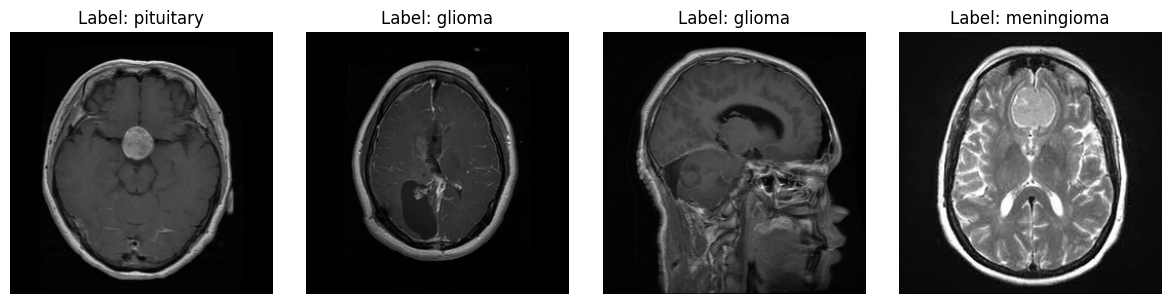

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_transform = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train = BrainTumorDataset(root_dir=path_training, transform=train_transform)
test = BrainTumorDataset(root_dir=path_testing, transform=train_transform)

train_loader = DataLoader(dataset=train, batch_size=16, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=16, shuffle=True)

train.plot_random_images(num_images=4)

In [130]:
class BrainTumorClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=4, stride=2),    # 512 -> 254
            nn.LeakyReLU(),
            nn.Conv2d(8, 16, kernel_size=4, stride=5),   # 254 -> 50
            nn.LeakyReLU(),
            nn.Conv2d(16, 16, kernel_size=4, stride=5),   # 50 -> 10
            nn.LeakyReLU(),
            nn.Conv2d(16, 16, kernel_size=4, stride=2),   # 10 -> 3
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(16, 4),
            nn.Sigmoid()  
        )

        self.training_accuracy = []
        self.testing_accuracy = []
    
    def forward(self, x):
        return self.model(x)
    
model = BrainTumorClassifier().to(device)
test_tensor = torch.randn(1, 3, 256, 256).to(device)
model.forward(test_tensor).shape
summary(model, input_size=(3, 256, 256), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 127, 127]             392
         LeakyReLU-2          [-1, 8, 127, 127]               0
            Conv2d-3           [-1, 16, 25, 25]           2,064
         LeakyReLU-4           [-1, 16, 25, 25]               0
            Conv2d-5             [-1, 16, 5, 5]           4,112
         LeakyReLU-6             [-1, 16, 5, 5]               0
            Conv2d-7             [-1, 16, 1, 1]           4,112
         LeakyReLU-8             [-1, 16, 1, 1]               0
           Flatten-9                   [-1, 16]               0
           Linear-10                    [-1, 4]              68
          Sigmoid-11                    [-1, 4]               0
Total params: 10,748
Trainable params: 10,748
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/ba

In [135]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BrainTumorClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 200

# model.load_state_dict(torch.load("simple brain cancer convolutional model2.pth"))

Training Progress:   0%|          | 0/200 [00:00<?, ?it/s]

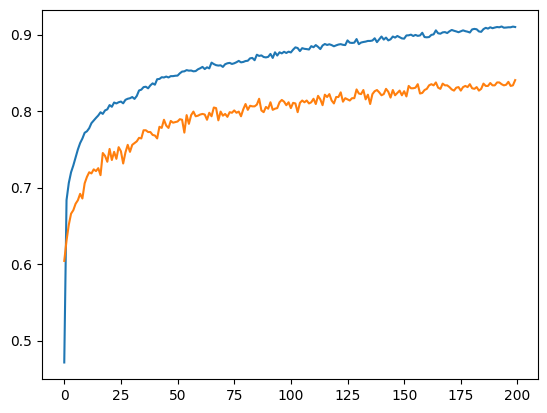

In [136]:
pbar = tqdm(range(num_epochs), desc="Training Progress")

for epoch in pbar:
    starting_time = time.time()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    correct = 0 # For testing
    
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_predictions

    # Adding the test accuracy (at the cost of computational speed)
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            correct += (torch.argmax(outputs, 1) == labels).sum().item()
        test_accuracy = correct / len(test_loader.dataset)

    model.training_accuracy.append(epoch_accuracy)
    model.testing_accuracy.append(test_accuracy)

    elapsed_minutes = (time.time() - starting_time) / 60
    log_message = (f"Loss: {epoch_loss:.4f}, "
        f"Train Acc: {epoch_accuracy:.4f}, "
        f"Test Acc: {test_accuracy:.4f}, "
        f"Time: {elapsed_minutes:.1f}m")
    pbar.set_postfix_str(log_message)
    
torch.save(model.state_dict(), "simple_brain_cancer_convolutional_model.pth")

plt.plot(range(num_epochs), model.training_accuracy, label='Training Accuracy')
plt.plot(range(num_epochs), model.testing_accuracy, label='Testing Accuracy')

In [ ]:
# def integrated_gradients(inputs, model, target_class=None, steps=50):
#     model.eval()
#     device = inputs.device
    
#     if target_class is None:
#         with torch.no_grad():
#             target_class = model(inputs).argmax(dim=1)
#     elif isinstance(target_class, int):
#         target_class = torch.tensor([target_class] * inputs.size(0), device=device)
    
#     baseline = torch.zeros_like(inputs)
#     gradients = torch.zeros_like(inputs)
    
#     for i in tqdm(range(steps)):
#         alpha = (i + 0.5) / steps
#         interpolated = baseline + alpha * (inputs - baseline)
#         interpolated.requires_grad_(True)
        
#         outputs = model(interpolated)
#         target_output = outputs.gather(1, target_class.unsqueeze(1)).sum()
        
#         grad = torch.autograd.grad(target_output, interpolated)[0]
#         gradients += grad
    
#     gradients *= (inputs - baseline) / steps
#     return gradients

# def show_attribution_overlays(images, attributions, labels, indices, model, title="Attribution Overlays"):
    
#     n_samples = len(indices)
#     fig, axes = plt.subplots(1, n_samples, figsize=(4 * n_samples, 4))
    
#     # Handle single subplot case
#     if n_samples == 1:
#         axes = [axes]
    
#     for i, idx in enumerate(indices):
#         # Get image
#         img = images[idx].squeeze().detach().cpu()
#         if img.dim() == 3:
#             img = img.permute(1, 2, 0)
        
#         # Get attribution
#         attr = attributions[idx].squeeze().detach().cpu()
#         if attr.dim() == 3:
#             attr = attr.abs().sum(dim=0)
#         else:
#             attr = attr.abs()
        
#         # Get label
#         label_idx = labels[idx].item() if hasattr(labels[idx], 'item') else labels[idx]
#         label_name = label_map_inv.get(label_idx, f"Unknown({label_idx})")
        
#         # Create overlay
#         axes[i].imshow(img, cmap='gray', alpha=0.7)
#         axes[i].imshow(attr, cmap='hot', alpha=0.4)
#         axes[i].set_title(f'Sample {idx}\n{label_name}')
#         axes[i].axis('off')
    
#     plt.suptitle(title)
#     plt.tight_layout()
#     plt.show()


def calculate_integrated_gradients(model: nn.Module, input_tensor: torch.Tensor, target_class_index: int, baselines=None, steps: int = 50):
    ig = IntegratedGradients(model)
    attributions = ig.attribute(input_tensor, target=target_class_index, baselines=baselines, n_steps=steps)
    return attributions

calculate_integrated_gradients(model=model, input_tensor=test._X[0].unsqueeze(0).to(device), target_class_index=0, steps=50)

In the image below, it is not clear which exact pixels were most important in the decision making. 

We need to make sure that the Integrated Gradients algorithm is implemented correctly. Lets use Captum

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].


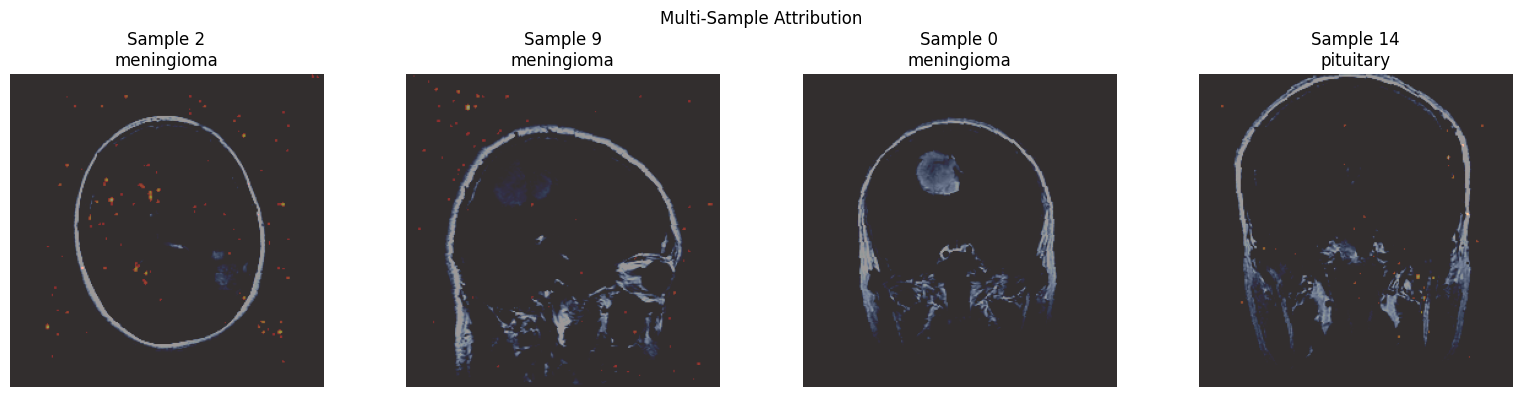

In [ ]:
idx = torch.randperm(16)[:4]
ig = integrated_gradients(batch[0], model)
ig = torch.where(ig < 0.1, 0, ig)
show_attribution_overlays(batch[0], ig, batch[1], idx, model, "Multi-Sample Attribution")

Next, we try to use ResNet18 as a foundation model, freeze its weights and use its feature extraction to classify the tumors

In [149]:
class BrainTumorResNet18(nn.Module):
    def __init__(self):
        super(BrainTumorResNet18, self).__init__()
        # Load ResNet18 and freeze its layers
        self.resnet = models.resnet18(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        # Get the number of features from the last layer
        num_features = self.resnet.fc.in_features
        
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, num_features // 2),
            nn.LeakyReLU(),
            nn.Linear(num_features // 2, 4),
            nn.Sigmoid()
        )
        
        self.training_accuracy = []
        self.testing_accuracy = []
        
    def forward(self, x):
        return self.resnet(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_transform = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.ToTensor(),  # Added ToTensor() - needed for proper tensor conversion
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/357 [00:00<?, ?it/s]

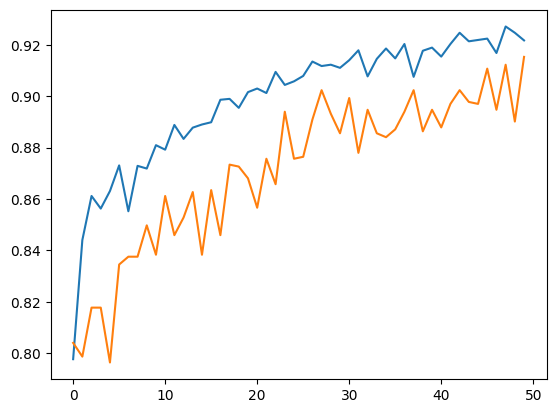

In [150]:
model = BrainTumorResNet18()
model = model.to(device)

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-3)
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 50  
pbar = tqdm(range(num_epochs), desc="Training Progress")
for epoch in pbar:
    starting_time = time.time()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    correct = 0  # For testing
   
    model.train()
    batch_loader = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for inputs, labels in batch_loader:
        inputs, labels = inputs.to(device), labels.to(device)
       
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
       
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        batch_loader.set_postfix(loss=loss.item())
   
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_predictions
    
    # Adding the test accuracy (takes a bit longer)
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            correct += (torch.argmax(outputs, 1) == labels).sum().item()
        test_accuracy = correct / len(test_loader.dataset)
    
    model.training_accuracy.append(epoch_accuracy)
    model.testing_accuracy.append(test_accuracy)
    elapsed_minutes = (time.time() - starting_time) / 60
    log_message = (f"Loss: {epoch_loss:.4f}, "
        f"Train Acc: {epoch_accuracy:.4f}, "
        f"Test Acc: {test_accuracy:.4f}, "
        f"Time: {elapsed_minutes:.1f}m")
    pbar.set_postfix_str(log_message)

# Save model
torch.save(model.state_dict(), "simple_brain_cancer_convolutional_model_resnet18.pth")

plt.plot(range(num_epochs), model.training_accuracy, label='Training Accuracy')
plt.plot(range(num_epochs), model.testing_accuracy, label='Testing Accuracy')

  0%|          | 0/50 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].


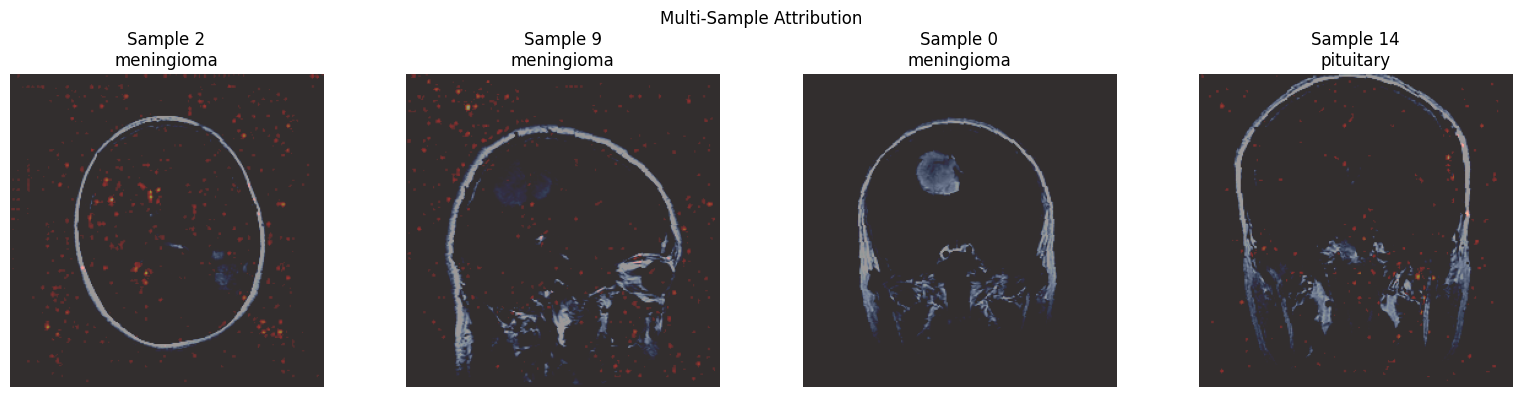

In [153]:
# idx = torch.randperm(16)[:4]
ig = integrated_gradients(batch[0], model)
ig = torch.where(ig < 0.05, 0, ig)

show_attribution_overlays(batch[0], ig, batch[1], idx, model, "Multi-Sample Attribution")